In [4]:
%pylab inline
import pandas as pd
from functools import reduce, lru_cache

Populating the interactive namespace from numpy and matplotlib


# Data Preparation

In [5]:
all_data = pd.read_csv('ml-100k/u1.base', delimiter='\t', header=None)
all_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [6]:
tst_data = pd.read_csv('ml-100k/u1.test', delimiter='\t', header=None)
tst_data.columns = ['user_id', 'item_id', 'rating', 'timestamp']

In [7]:
users = max(all_data.user_id.max(), tst_data.user_id.max()) + 1
items = max(all_data.item_id.max(), tst_data.item_id.max()) + 1

In [8]:
train_matrix = zeros((users, items))
for i, r in all_data.iterrows():
    train_matrix[r.user_id, r.item_id] = r.rating

In [9]:
test_matrix = zeros((users, items))
for i, r in tst_data.iterrows():
    test_matrix[r.user_id, r.item_id] = r.rating

In [280]:
assert train_matrix.shape == test_matrix.shape

In [282]:
del all_data, tst_data # relase the memory for later use.

# Evaluation Metrics

In [125]:
mae = lambda p, r: mean(abs(r - p))

In [126]:
rmse = lambda p, r: sqrt(mean(pow(r-p, 2)))

In [273]:
def hmae(p, r, k=3):
    ri = r >= k
    return mean(abs(r[ri] - p[ri]))

# Algorithm Test

In [151]:
def get_simialrity_matrix(ratings, measure):
    # by default, we generate the similarity matrix by the first dimension.
    dlen = ratings.shape[0]
    item_similarity_matrix = zeros((dlen,) * 2)
    for i in range(dlen):
        for j in range(i+1, dlen):
            item_similarity_matrix[i, j] = item_similarity_matrix[j, i] = measure(ratings[i, :], ratings[j, :])
    return item_similarity_matrix

## Similarity Measures

In [67]:
def pearson_similarity(a, b):
    assert a.shape == b.shape
    overlap = (a > 0) & (b > 0)
    if any(overlap):
        va = a[overlap]
        vb = b[overlap]
        n = sqrt(sum(pow(va - mean(va), 2))) * sqrt(sum(pow(vb - mean(vb), 2)))
        if n == 0:
            return 0
        else:
            return round(sum((va - mean(va)) * (vb - mean(vb))) / n, 6)
    return 0

In [156]:
def diffratio_similarity(a, b):
    assert a.shape == b.shape
    overlap = (a > 0) & (b > 0)
    if any(overlap):
        va = a[overlap]
        vb = b[overlap]
        n = sqrt(sum(pow(va - mean(va), 2))) * sqrt(sum(pow(vb - mean(vb), 2)))
        if n == 0:
            return 0
        else:
            union = (a > 0) | (b > 0)
            contrib = count_nonzero(overlap) / count_nonzero(union)
            return contrib * round(sum((va - mean(va)) * (vb - mean(vb))) / n, 6)
    return 0

In [162]:
def diffratiolog_similarity(a, b):
    assert a.shape == b.shape
    overlap = (a > 0) & (b > 0)
    if any(overlap):
        va = a[overlap]
        vb = b[overlap]
        n = sqrt(sum(pow(va - mean(va), 2))) * sqrt(sum(pow(vb - mean(vb), 2)))
        if n == 0:
            return 0
        else:
            union = (a > 0) | (b > 0)
            contrib1 = count_nonzero(overlap) / count_nonzero(union)
            contrib2 = log(count_nonzero(overlap)) / log(count_nonzero(union))
            return contrib1 * contrib2 * round(sum((va - mean(va)) * (vb - mean(vb))) / n, 6)
    return 0

In [68]:
pearson_similarity(
    array([2,4,8]),
    array([1,2,4])
)

1.0

In [163]:
uu_sim3 = get_simialrity_matrix(train_matrix, diffratiolog_similarity)

In [157]:
uu_sim2 = get_simialrity_matrix(train_matrix, diffratio_similarity)

In [136]:
uu_sim = get_simialrity_matrix(train_matrix, pearson_similarity)

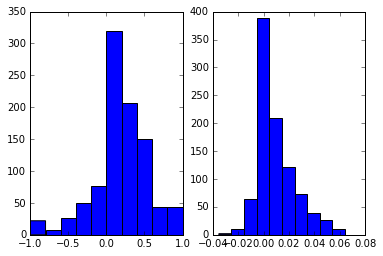

In [292]:
subplot(121); hist(uu_sim[1, :]); subplot(122); hist(uu_sim3[1, :]);

In [71]:
ii_sim = get_simialrity_matrix(train_matrix.T, pearson_similarity)

In [190]:
ii_sim2 = get_simialrity_matrix(train_matrix.T, diffratiolog_similarity)

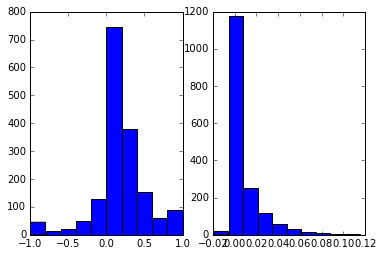

In [289]:
subplot(121); hist(ii_sim[1]); subplot(122); hist(ii_sim2[1]);

In [101]:
argsort([1,-1,3])

array([1, 0, 2])

In [103]:
array([1,2,3])[-10:]

array([1, 2, 3])

## Algorithm Framework

In [114]:
def cf(pairs, rating_matrix, similarity_matrix, agg=lambda p, r: sum(p * r) / sum(p)):
    result = []
    for u, i in pairs:
        p = similarity_matrix[u, :]
        r = rating_matrix[:, i]
        rating = agg(p[r>0], r[r>0])
        if isnan(rating):
            rating = mean(rating_matrix[u, :])
        result.append(rating)
    return array(result)

In [301]:
def all_agg(p, r):
    return sum(p * r) / sum(p)

In [120]:
def topk_agg(k):
    def agg(p, r):
        pi = argsort(p)
        sel_p = p[pi][-k:]
        sel_r = r[pi][-k:]
        return sum(sel_p[sel_p>0] * sel_r[sel_p>0]) / sum(sel_p[sel_p>0])
    return agg

# Cases Study

## Item-based Solution

In [229]:
prediction1 = cf(
    zip(*nonzero(test_matrix.T)),
    train_matrix.T,
    ii_sim,
    topk_agg(1000)
)

In [230]:
mae(test_matrix.T[nonzero(test_matrix.T)], prediction1)

0.84189091903689461

In [278]:
hmae(test_matrix.T[nonzero(test_matrix.T)], prediction1, 3)

0.82257234724864725

In [276]:
prediction2 = cf(
    zip(*nonzero(test_matrix.T)),
    train_matrix.T,
    ii_sim2,
    topk_agg(20)
)

In [267]:
mae(test_matrix.T[nonzero(test_matrix.T)], prediction2)

0.77422581689659165

In [279]:
hmae(test_matrix.T[nonzero(test_matrix.T)], prediction2, 3)

0.74534968878245256

## User-based Solution

In [294]:
upred1 = cf(
    zip(*nonzero(test_matrix)),
    train_matrix,
    uu_sim,
    topk_agg(40)
)

In [295]:
mae(test_matrix[nonzero(test_matrix)], upred1)

0.81203563856371952

In [296]:
upred2 = cf(
    zip(*nonzero(test_matrix)),
    train_matrix,
    uu_sim2,
    topk_agg(40)
)

In [297]:
mae(test_matrix[nonzero(test_matrix)], upred2)

0.80532432063515313

In [298]:
upred3 = cf(
    zip(*nonzero(test_matrix)),
    train_matrix,
    uu_sim3,
    topk_agg(40)
)

In [300]:
mae(test_matrix[nonzero(test_matrix)], upred3)

0.8052534465253689

# Conclusion

User-based solution outperforms item-based solution. However, when top k aggregation is adopted, item-based solution is no better than user-based solution. 

When Diff.Ratio.Log method is adopted, all results are improved.